# Thresholding
In order to be able to extract graphlets, HiC contact maps
should be modeled as unweighted graphs where the nodes
represent the loci and an edge between two nodes represent
a significant interaction between the loci. This can be
achieved by thresholding the contact maps. The result of the
thresholding procedure is a binary matrix which also can serve
as an adjacency matrix for an unweighted, undirected graph.
The graph can then be used for orbit extraction.

When thresholding contact maps, it is necessary to make
sure that both global and local features are maintained. We
could consider thresholding the contact maps by simply
setting values above a fixed value to one and the rest to
zero; However, in practice, this method resulted in graphs
that capture the local structure of the contact maps poorly.
This is because intensities follow an exponential distribution
with a mean close to zero with a few very larges values that
correspond to interactions along or close to the main diagonal
of the contact maps. Thus, picking relatively large numbers
would result in ignoring interactions that are far from the main
diagonal while picking small values will lead to capturing too
many (insignificant) interactions.

In order to threshold the contact map so that both global and
local patterns are captured, we borrowed the concept of
adaptive thresholding from image processing context. In
this method, in order to be set, a pixel should have an
intensity larger than the average of non-zero intensities in
its neighborhood. The neighborhood is defined by a sliding
kernel that passes through the contact map with the pixel at
its middle at each step. 

In this notebook, we implement the local thresholding on 
the original contact maps. Here, we assume that the grand contact
map of all inter- and intra-chromosomal contact maps 
has been created and saved as a numpy array (\*.npy) format. 

In [1]:
import numpy as np
import cv2
from iced import filter
from iced import normalization
from utility import *
import matplotlib.pyplot as plt
from matplotlib import colors
from iced import normalization
from iced import filter
from scipy.stats import t
import os
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/bzr0014/watson/scripts/virt/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['colors', 'log']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Loading the data
Contact maps of each cell are identified by a grand matrix holding all interactions between all loci.
This grand matrix is a symmteric matrix of size $N \times N$ where $N$ is the total number of loci
in all chromosomes. Each rows and colums represent all loci in all chromosomes.
In order to separate contact maps from each other, a `lengths` is used which
is a $23 \times 2$ matrix that holds the beginning(`[lengths[][0]`)
and length (`lengths[][1]`) of each chromosome
in terms of loci in each chromosome.

In [8]:
data_names = ["MIT", "ALL", "RL", "call4"]
file_dir_template = "../data/extracted_all_contact_%s"
file_name_template = "%s/all_in_one_500kb.npy"%(file_dir_template)
print("File Directory: \"%s\""%file_dir_template)
print("File Name Template: \"%s\""%file_name_template)

File Directory: "../data/extracted_all_contact_%s"
File Name Template: "../data/extracted_all_contact_%s/all_in_one_500kb.npy"


In [9]:
data = {}
for key in data_names:
    data[key] = np.load(file_name_template%key)
    print("file for %s has been loaded"%key)

file for MIT has been loaded
file for ALL has been loaded
file for RL has been loaded
file for call4 has been loaded


In [10]:
lengths = {}
for key in data_names:
    lengths[key] = np.load("%s/lengths_500kb.npy"%(file_dir_template%key))

In [17]:
lengths

{'ALL': array([[   0,    0],
        [   0,  495],
        [ 495,  486],
        [ 981,  399],
        [1380,  383],
        [1763,  362],
        [2125,  342],
        [2467,  318],
        [2785,  293],
        [3078,  281],
        [3359,  271],
        [3630,  269],
        [3899,  265],
        [4164,  229],
        [4393,  213],
        [4606,  201],
        [4807,  178],
        [4985,  158],
        [5143,  153],
        [5296,  128],
        [5424,  125],
        [5549,   94],
        [5643,  100],
        [5743,  310]], dtype=uint32), 'MIT': array([[   0,    0],
        [   0,  495],
        [ 495,  486],
        [ 981,  399],
        [1380,  383],
        [1763,  362],
        [2125,  342],
        [2467,  318],
        [2785,  293],
        [3078,  281],
        [3359,  271],
        [3630,  269],
        [3899,  265],
        [4164,  229],
        [4393,  213],
        [4606,  201],
        [4807,  178],
        [4985,  158],
        [5143,  153],
        [5296,  128],
   

### Plotting the grand contact maps

Number of rows and columns: 2, 2


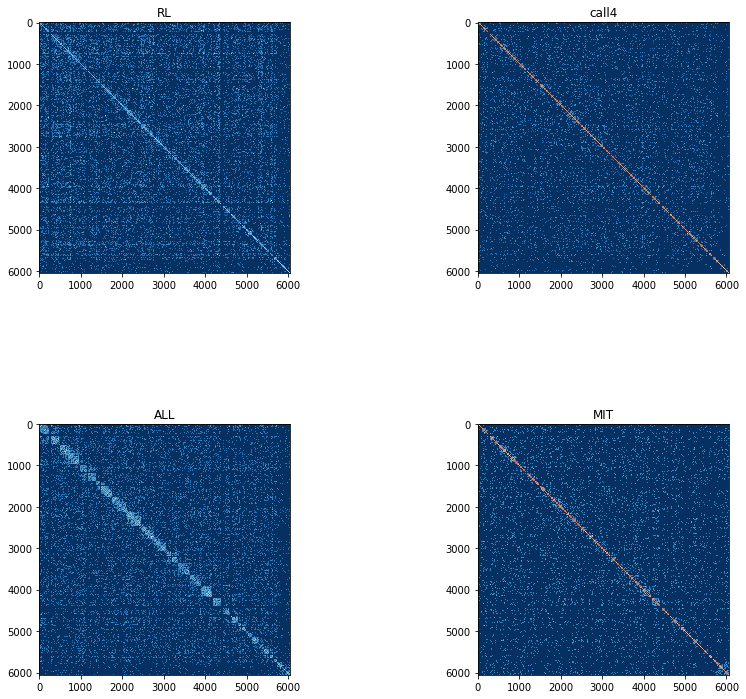

In [12]:
pylab.rcParams['figure.figsize'] = (15, 12)
showImages(data, 2)

## Contact map normalization
In order to get rid of noise, we need to perform some normalizations that accentuate
actual interactions while getting rid of noise. In order to achieve this, we have
used `ice` normalization. Make sure you have installed the package under the `/iced`
directory. In the following code, first we get rid of the lower $4\%$ of interactions
and then perform ice normalization.

In [ ]:
normed = {}
for key in data_names:
    normed[key] = filter.filter_low_counts(data[key], lengths=lengths[key][:, 1], percentage=.04)
    normed[key] = normalization.ICE_normalization(normed[key])
    print("finished normalizing %s"%key)

Number of rows and columns: 2, 2


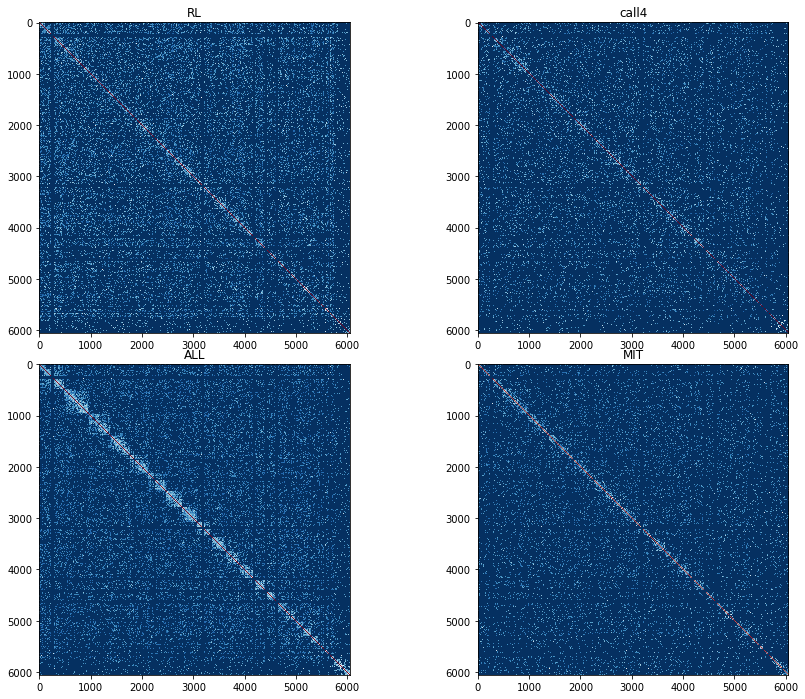

In [33]:
pylab.rcParams['figure.figsize'] = (15, 12)
showImages(normed, 2)

# Thresholding
Once we have the normalized contact maps, it is time to do the
thresholding, This proces may take a long time depending on
the thresholding method and kernel size. We have already
saved the results of thresholding that we have used 
which is loaded automatically by the following code.
If you want to do your own thresholding, feel free
to comment out line `9-12` of the code block below.

file MIT already exists...
file ALL already exists...
file RL already exists...
file call4 already exists...
Number of rows and columns: 2, 2


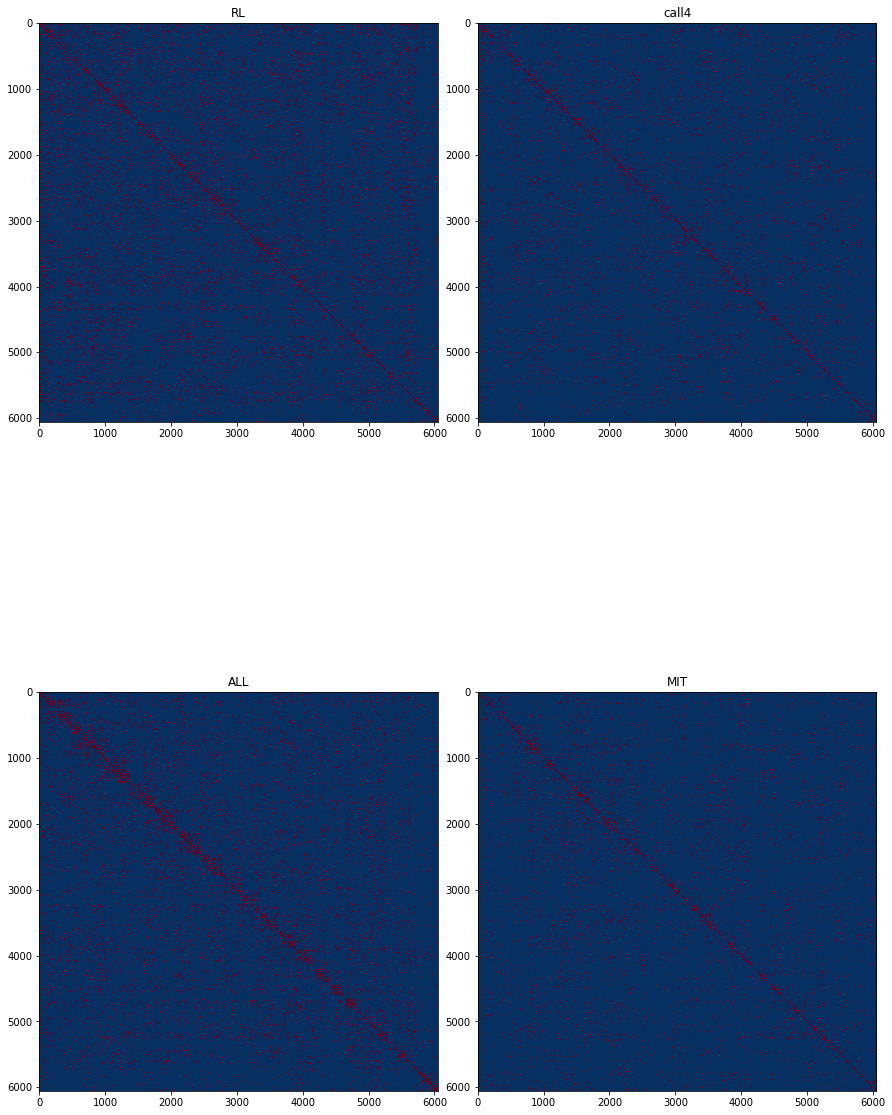

In [14]:
pylab.rcParams['figure.figsize'] = (15, 20)
k = (2, 2, 2, 2)
method = 'normal'
t = 0
params = None
symmetric=True
thresholded = {}
for name in data_names:
    filename = "%s/all_in_one_thresholded_500kb.npy"%(file_dir_template%name)
    if os.path.isfile(filename):
        print("file %s already exists..."%name)
        thresholded[name] = np.load(filename)
    else:
        thresholded[name] = local_threshold(normed[name], k=k, method=method\
                                          , t=t, params=params)
showImages(thresholded, 2) 

In [22]:
## This code block is used only to save the results of the thresholding
## If you have used the already saved data, please ignore it.
#for key in data_names:
#    data[key] = np.save\
#    ("%s/all_in_one_thresholded_500kb.npy"%(file_dir_template%key) , \
#     thresholded[key].astype('uint8'))
#    print("file for %s has been saved"%key)

file for MIT has been saved
file for ALL has been saved
file for RL has been saved
file for call4 has been saved


## Comparing thresholded contact maps
We can now perform comparisons between thresholded contact maps. Particularly, we can visualize where two same contact
maps from different cells are similar or different.

Number of rows and columns: 4, 4


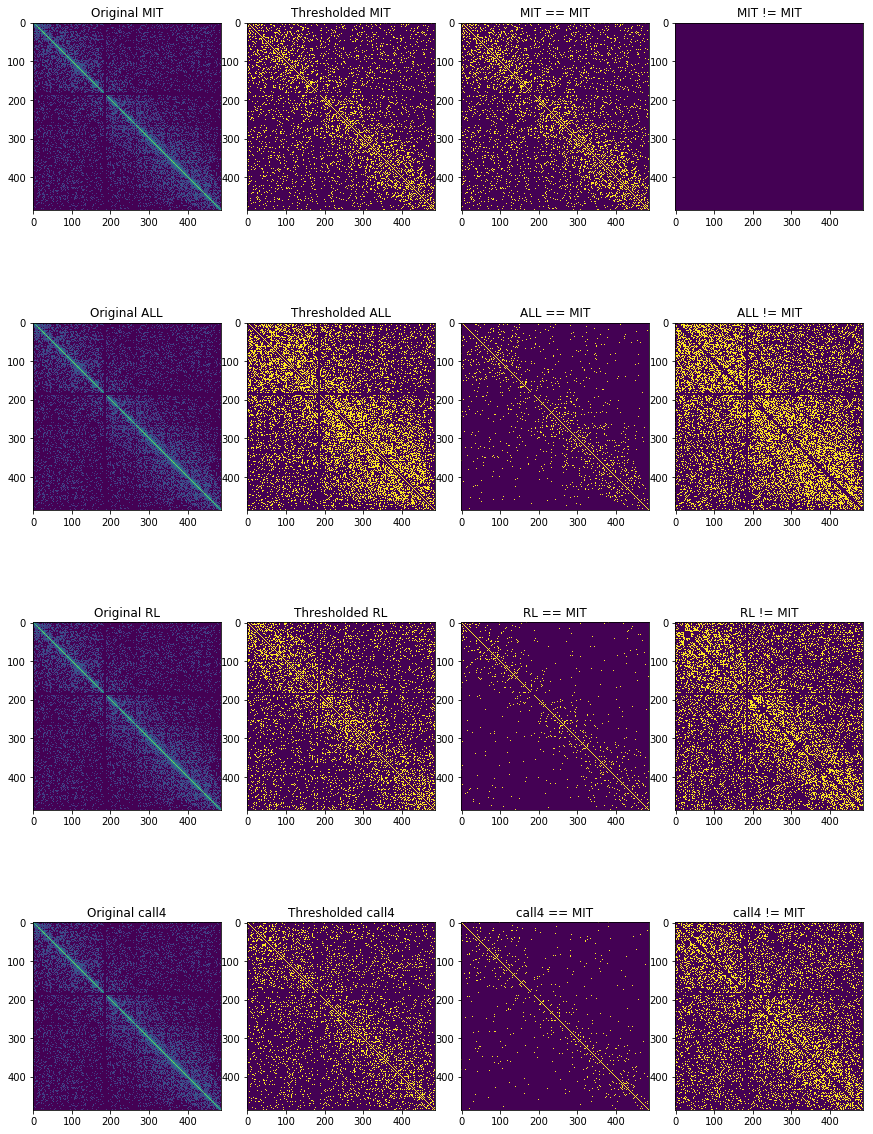

In [27]:
images = []
titles = []
chr1 = 2
chr2 = 2
for name1 in data_names:
    if name1 != 'MIT':
        continue
    l1 = lengths[name1][chr1]
    l2 = lengths[name1][chr2]
    for name2 in data_names:
        images.append(data[name1][l1[0]:l1[0]+l1[1], l2[0]:l2[0]+l2[1]])
        titles.append("Original %s"%name2)
        
        images.append(thresholded[name2][l1[0]:l1[0]+l1[1], l2[0]:l2[0]+l2[1]])
        titles.append("Thresholded %s"%name2)
        
        images.append((thresholded[name2][l1[0]:l1[0]+l1[1], l2[0]:l2[0]+l2[1]]*1. \
                       * thresholded[name1][l1[0]:l1[0]+l1[1], l2[0]:l2[0]+l2[1]]*1.) )
        titles.append("%s == %s"%(name2, name1))           
        images.append((thresholded[name2][l1[0]:l1[0]+l1[1], l2[0]:l2[0]+l2[1]]*1. - \
                       thresholded[name1][l1[0]:l1[0]+l1[1], l2[0]:l2[0]+l2[1]]*1.) != 0)
        titles.append("%s != %s"%(name2, name1))
        #images.append((thresholded[name2][:lengths[name2][1, 1], :lengths[name2][1, 1]]*1. - \
        #               thresholded[name1][:lengths[name1][1, 1], :lengths[name1][1, 1]]*1.) < 0)
        #titles.append("%s - %s"%(name1, name2))       
showImages(images, cols = 4, titles=titles, cmap=None\
       , save_dir="papers/manuscripts/figures/local_thresholded_chr1_chr1.png")

        

**The following code block saves the thresholded results in a way that `orca` can read them and extract
graphlets from them. This needs to be done only once for each thresholding, so if you have
kept everything unchanged in this notebook, you don't need to run it.**

In [29]:
##saving intrachromosomal files for orca
#images = []
#titles = []
#axes = {'x':[], 'y':[]}
#for name in data_names:
#    for chr1 in range(1, 24):
#        for chr2 in range(chr1, 24):
#            filename = "data/chr%02d_chr%02d_%s.edges"%(chr1, chr2, name.lower())
#            l1 = lengths[name][chr1, :]
#            l2 = lengths[name][chr2, :]
#            if chr1 == chr2:
#                y_beg = 0
#            else:
#                y_beg = l1[1]
#            convertBinaryMatToOrcaReadable(thresholded[name][l1[0]:l1[0]+l1[1], l2[0]:l2[0]+l2[1]], filename\
#                                          , y_beg = y_beg)
#            #images.append(thresholded[name][l1[0]:l1[0]+l1[1], l2[0]:l2[0]+l2[1]])
#            #titles.append(name)
#            #axes['x'].append("chr %d"%chr1)
#            #axes['y'].append("chr %d"%chr2)
##showImages(images, cols = 3, titles=titles, ax_labels=axes, cmap=None)